In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from gatspy import datasets
from scipy.interpolate import interp1d
import sys
import pickle
from photutils import create_matching_kernel
from astropy.convolution import convolve
from photutils import TopHatWindow
import cv2
from skimage import transform as tf
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
save_path = "chapter2_plots/"
plot_fontsize = 18
plot_figsize = (15, 6)

# Activation function

In [17]:
x_vector = np.arange(-10, 10, step=0.01)

def sigmoid(x):
    h = np.exp(x)/(np.exp(x)+1)
    return h

def ReLU(x):
    h = np.amax(np.concatenate([np.zeros(shape=x.shape)[..., np.newaxis], 
                                x[..., np.newaxis]], axis=1), axis=1)
    return h

function_list = [sigmoid, np.tanh, ReLU]
function_names = ["Sigmoid", "Hyperbolic tangent", "ReLU"]

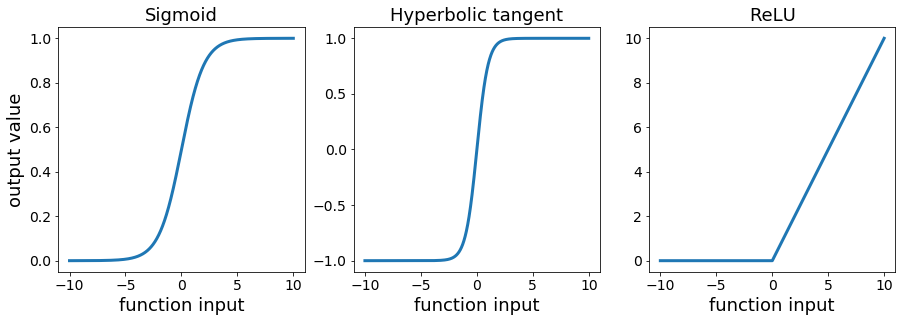

In [18]:
f, ax = plt.subplots(1, 3, figsize=(15,4.5))
for i, func in enumerate(function_list):
    ax[i].plot(x_vector, function_list[i](x_vector), lw=3)
    ax[i].set_title(function_names[i], fontsize=plot_fontsize)
    ax[i].set_xlabel("function input", fontsize=plot_fontsize)
    #ax[i].set_ylabel("output value", fontsize=plot_fontsize)
    ax[i].tick_params(axis='both', which='major', labelsize=plot_fontsize-4)
ax[0].set_ylabel("output value", fontsize=plot_fontsize)
plt.savefig(save_path+"activation_functions.pdf", bbox_inches = 'tight')
plt.show()

# Overfitting example

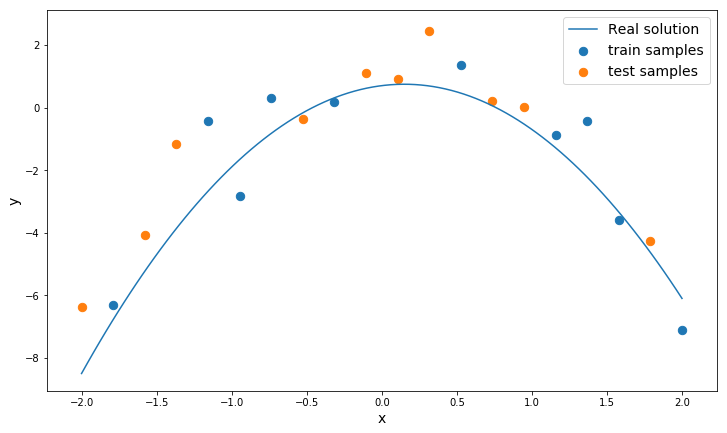

Generalization errors
linear: 8.279994249288725
quadratic: 1.1268153752396755
deg5: 2.0717987949793124
deg10: 17195.81609063237


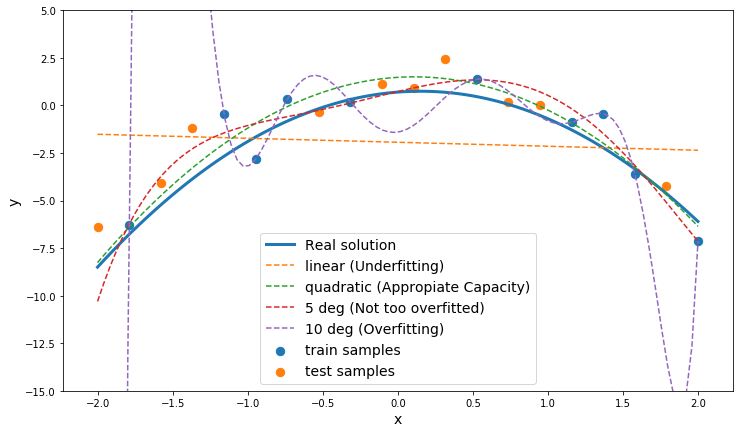

In [20]:
def linear_function(w, x):
    return np.dot(x, w)

w = np.array([-2, 0.6, 0.7])[...,np.newaxis]
noise = 1.2
n_points = 20
train_size = 10
test_size = n_points - train_size

np.random.seed(0)

x_samples = np.linspace(-2, 2, n_points)[..., np.newaxis]
# Making quadratic polinomial
augmented_x = np.concatenate([x_samples**2, x_samples, x_samples**0], axis=1)
y_samples = linear_function(w, augmented_x) + np.random.normal(loc=0.0, scale=noise, size=(n_points,1))
x_plot = np.linspace(-2,2,100)[..., np.newaxis]
aug_x_plot = np.concatenate([x_plot**2, x_plot, x_plot**0], axis=1)

# Dividing in train and test set
indexes = np.arange(start=0, stop=n_points,step=1)
np.random.shuffle(indexes)
train_index = indexes[:train_size]
test_index = indexes[train_size:]
x_train = x_samples[train_index, ...]
aug_x_train = augmented_x[train_index, ...]
y_train = y_samples[train_index, ...]
x_test = x_samples[test_index, ...]
aug_x_test = augmented_x[test_index, ...]
y_test = y_samples[test_index, ...]

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(x_plot, linear_function(w, aug_x_plot), label="Real solution")
ax.scatter(x_train, y_train, label="train samples", s=70)
ax.scatter(x_test, y_test, label="test samples", s=70)
ax.legend(fontsize=14)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
plt.show()

# Linear, Quadratic 5 and 10 degree polynomial fit.
linear_coef = np.polyfit(x_train[:, 0], y_train[:, 0], deg=1, full=True) 
qd_coef = np.polyfit(x_train[:, 0], y_train[:, 0], deg=2,full=True)
deg5_coef = np.polyfit(x_train[:, 0], y_train[:, 0], deg=5, full=True) 
deg10_coef = np.polyfit(x_train[:, 0], y_train[:, 0], deg=10, full=True) 
p1 = np.poly1d(linear_coef[0])
p2 = np.poly1d(qd_coef[0])
p3 = np.poly1d(deg5_coef[0])
p4 = np.poly1d(deg10_coef[0])
error1 = np.linalg.norm(y_test[:, 0] - p1(x_test[:, 0]))**2/len(y_test)
error2 = np.linalg.norm(y_test[:, 0] - p2(x_test[:, 0]))**2/len(y_test)
error3 = np.linalg.norm(y_test[:, 0] - p3(x_test[:, 0]))**2/len(y_test)
error4 = np.linalg.norm(y_test[:, 0] - p4(x_test[:, 0]))**2/len(y_test)

print("Generalization errors")
print("linear: "+str(error1))
print("quadratic: "+str(error2))
print("deg5: "+str(error3))
print("deg10: "+str(error4))
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(x_plot, linear_function(w, aug_x_plot), label="Real solution", lw=3)
ax.scatter(x_train, y_train, label="train samples", s=70)
ax.scatter(x_test, y_test, label="test samples", s=70)
ax.plot(x_plot, p1(x_plot),'--' ,label="linear (Underfitting)")
ax.plot(x_plot, p2(x_plot),'--' , label="quadratic (Appropiate Capacity)")
ax.plot(x_plot, p3(x_plot),'--' , label="5 deg (Not too overfitted)" )
ax.plot(x_plot, p4(x_plot),'--' , label="10 deg (Overfitting)")
ax.legend(fontsize=14)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
ax.set_ylim([-15, 5])
plt.show()



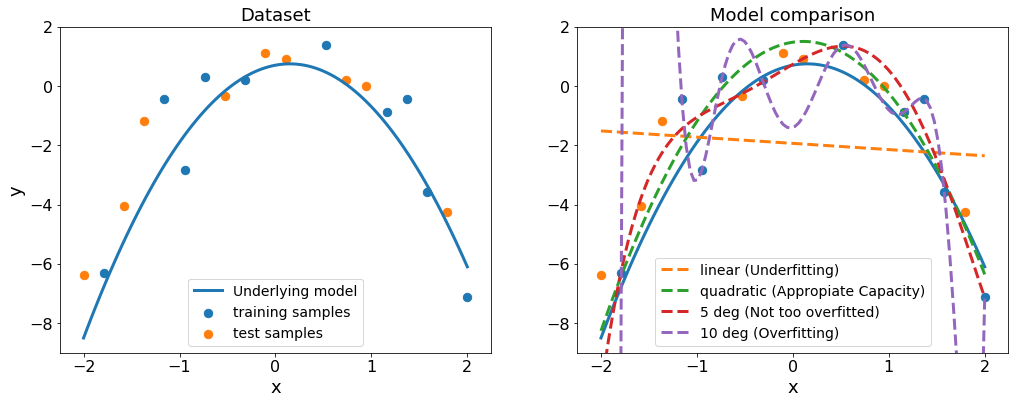

In [34]:
f, ax = plt.subplots(1, 2, figsize=(17,6))
ax[0].plot(x_plot, linear_function(w, aug_x_plot), label="Underlying model", lw=3)
ax[0].scatter(x_train, y_train, label="training samples", s=70)
ax[0].scatter(x_test, y_test, label="test samples", s=70)
ax[0].legend(fontsize=plot_fontsize-4)
ax[0].set_title("Dataset", fontsize=plot_fontsize)
ax[0].set_xlabel("x", fontsize=plot_fontsize)
ax[0].set_ylabel("y", fontsize=plot_fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=plot_fontsize-2)
ax[0].set_ylim([-9, 2])

ax[1].plot(x_plot, linear_function(w, aug_x_plot), lw=3)
ax[1].scatter(x_train, y_train, s=70)
ax[1].scatter(x_test, y_test, s=70)
ax[1].plot(x_plot, p1(x_plot),'--' ,label="linear (Underfitting)", lw=3)
ax[1].plot(x_plot, p2(x_plot),'--' , label="quadratic (Appropiate Capacity)", lw=3)
ax[1].plot(x_plot, p3(x_plot),'--' , label="5 deg (Not too overfitted)", lw=3 )
ax[1].plot(x_plot, p4(x_plot),'--' , label="10 deg (Overfitting)", lw=3)
ax[1].legend(fontsize=plot_fontsize-4)
ax[1].set_title("Model comparison", fontsize=plot_fontsize)
ax[1].set_xlabel("x", fontsize=plot_fontsize)
ax[1].set_ylabel("", fontsize=plot_fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=plot_fontsize-2)
ax[1].set_ylim([-9, 2])

plt.savefig(save_path+"overfitting_example.pdf", bbox_inches = 'tight')
plt.show()